<a href="https://colab.research.google.com/github/SusannaPinotti/GPT-2_JOKES_GENERATION/blob/main/JOKES_GPT2_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture 
!pip install transformers
!pip install datasets

In [ ]:
import pandas as pd
import torch 
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
jks = pd.read_csv('/content/drive/MyDrive/JKS.csv')
jks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231657 entries, 0 to 231656
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Joke    231657 non-null  object
dtypes: object(1)
memory usage: 1.8+ MB


In [ ]:
jks.head()

,Joke
0,"[me narrating a documentary about narrators] ""..."
1,Telling my daughter garlic is good for you. Go...
2,I've been going through a really rough period ...
3,"If I could have dinner with anyone, dead or al..."
4,Two guys walk into a bar. The third guy ducks.


In [ ]:
#split test and train set
train, test = train_test_split(jks, test_size = 0.20, shuffle = True)
print(len(train))
print(len(test))
#train.to_csv("train.csv", index = False)
#test.to_csv('test.csv', index = False)

185325
46332


In [ ]:
from datasets import load_dataset

dataset = load_dataset('csv', data_files = {'train': '/content/drive/MyDrive/jokes_project/data/train.csv', 'test':'/content/drive/MyDrive/jokes_project/data/test.csv'})

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-bbb0cd81d6d12186/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from transformers import AdamW, AutoTokenizer, DataCollatorForLanguageModeling 
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer = tokenizer, mlm = False) #non masked language model

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def tokenize(examples): 
    return tokenizer(examples['Joke'], padding = True)

In [ ]:
tok_dataset = dataset.map(tokenize, remove_columns = ['Joke'])

  0%|          | 0/185325 [00:00<?, ?ex/s]

  0%|          | 0/46332 [00:00<?, ?ex/s]

In [ ]:
print(tok_dataset['train'])

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 185325
})


In [ ]:
print(tok_dataset['test'])

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 46332
})


In [ ]:
print(tokenizer.convert_ids_to_tokens(tok_dataset["train"]["input_ids"][1]))

['What', 'Ġwas', 'Ġthe', 'Ġhardest', 'Ġpart', 'Ġof', 'Ġbeing', 'Ġhappy', 'Ġin', 'Ġthe', 'Ġ1920', "'s", '?', 'ĠT', 'elling', 'Ġyour', 'Ġparents', 'Ġyou', "'re", 'Ġgay', '.']


In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("gpt2", resid_pdrop = 0.5) #avoid overfitting: turn off some neurons randomly at each epoch and let the other learn and adapt. 
embedding_layer = model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
from transformers import TrainingArguments
#choosing small batch size with low learning rate: 
training_args = TrainingArguments(output_dir = "/content/drive/MyDrive/checkpoints_5",  
                                  overwrite_output_dir= True, 
                                  logging_first_step = True, 
                                  num_train_epochs= 5,  
                                  evaluation_strategy='steps', 
                                  per_device_train_batch_size=8, 
                                  per_device_eval_batch_size=8,
                                  warmup_steps = 200,
                                  save_steps = 1000, 
                                  eval_steps = 500, 
                                  gradient_accumulation_steps= 3, #train on bigger batch sizes than your machine would normally be able to fit into memory. This is done by accumulating gradients over several batches
                                  weight_decay= 0.3, #another parameter to avoid overfitting 
                                  learning_rate = 5e-5
                                  )

In [ ]:
from transformers import Trainer
trainer = Trainer(model = model, 
                  args = training_args, 
                  train_dataset = tok_dataset['train'], 
                  eval_dataset= tok_dataset['test'], 
                  data_collator = data_collator,
                  tokenizer = tokenizer
                  )

In [ ]:
trainer.train('/content/drive/MyDrive/checkpoints_5/checkpoint-37000')
#trainer.train()

Loading model from /content/drive/MyDrive/checkpoints_5/checkpoint-37000.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 185325
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 3
  Total optimization steps = 38610
  Number of trainable parameters = 124439808
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 4
  Continuing training from global step 37000
  Will skip the first 4 epochs then the first 18336 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch comm

  0%|          | 0/18336 [00:00<?, ?it/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
37500,3.724500,3.564706
38000,3.718800,3.564450
38500,3.742600,3.564402


***** Running Evaluation *****
  Num examples = 46332
  Batch size = 8
***** Running Evaluation *****
  Num examples = 46332
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/checkpoints_5/checkpoint-38000
Configuration saved in /content/drive/MyDrive/checkpoints_5/checkpoint-38000/config.json
Model weights saved in /content/drive/MyDrive/checkpoints_5/checkpoint-38000/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/checkpoints_5/checkpoint-38000/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/checkpoints_5/checkpoint-38000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 46332
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=38610, training_loss=0.15535084512745645, metrics={'train_runtime': 1085.469, 'train_samples_per_second': 853.663, 'train_steps_per_second': 35.57, 'total_flos': 1.7694925037568e+16, 'train_loss': 0.15535084512745645, 'epoch': 5.0})

In [ ]:
import math 
eval = trainer.evaluate()
print(f'Perplexity: {math.exp(eval["eval_loss"]):.2f}')

***** Running Evaluation *****
  Num examples = 46332
  Batch size = 8


Perplexity: 35.32


[{'epoch': 0.0, 'learning_rate': 2.5000000000000004e-07, 'loss': 5.3387, 'step': 1}, {'epoch': 0.06, 'learning_rate': 4.9609476698776365e-05, 'loss': 4.9932, 'step': 500}, {'epoch': 0.06, 'eval_loss': 4.093564033508301, 'eval_runtime': 175.1038, 'eval_samples_per_second': 264.597, 'eval_steps_per_second': 33.078, 'step': 500}, {'epoch': 0.13, 'learning_rate': 4.89586045300703e-05, 'loss': 4.762, 'step': 1000}, {'epoch': 0.13, 'eval_loss': 4.0187788009643555, 'eval_runtime': 174.1247, 'eval_samples_per_second': 266.085, 'eval_steps_per_second': 33.264, 'step': 1000}, {'epoch': 0.19, 'learning_rate': 4.830773236136423e-05, 'loss': 4.6152, 'step': 1500}, {'epoch': 0.19, 'eval_loss': 3.9666826725006104, 'eval_runtime': 174.7256, 'eval_samples_per_second': 265.17, 'eval_steps_per_second': 33.149, 'step': 1500}, {'epoch': 0.26, 'learning_rate': 4.7656860192658164e-05, 'loss': 4.5207, 'step': 2000}, {'epoch': 0.26, 'eval_loss': 3.9393022060394287, 'eval_runtime': 174.6831, 'eval_samples_per_s

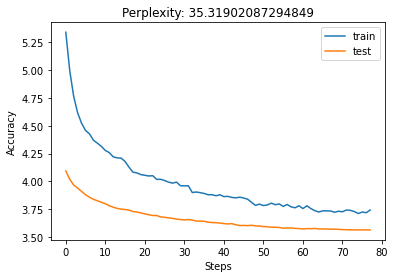

In [ ]:
import matplotlib.pyplot as plt
history = trainer.state.log_history 
print(history)
print(len(history))

steps = []
train_loss = []
eval_loss = []
i = 0
while i <= len(history): 
    if i < 2 : 
        train_loss.append(history[i]['loss'])
    elif i % 2 != 0: 
        try:
          train_loss.append(history[i]['loss'])
        except: 
          pass
    else:  
      eval_loss.append(history[i]['eval_loss'])
      steps.append(history[i]['step'])
    i = i +1 

plt.plot(train_loss)
plt.plot(eval_loss)
plt.title('Perplexity: '+str(math.exp(eval['eval_loss'])))
plt.ylabel('Accuracy')
plt.xlabel('Steps')
plt.legend(['train', 'test'], loc ='best')
plt.savefig('/content/drive/MyDrive/Model_accuracy_test5.png')
plt.show()

In [ ]:
trainer.save_model('/content/drive/MyDrive/jokes_project/model5FINAL')
tokenizer.save_pretrained('/content/drive/MyDrive/jokes_project/model5FINAL')

Saving model checkpoint to /content/drive/MyDrive/jokes_project/model5FINAL
Configuration saved in /content/drive/MyDrive/jokes_project/model5FINAL/config.json
Model weights saved in /content/drive/MyDrive/jokes_project/model5FINAL/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/jokes_project/model5FINAL/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/jokes_project/model5FINAL/special_tokens_map.json
tokenizer config file saved in /content/drive/MyDrive/jokes_project/model5FINAL/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/jokes_project/model5FINAL/special_tokens_map.json


('/content/drive/MyDrive/jokes_project/model5FINAL/tokenizer_config.json',
 '/content/drive/MyDrive/jokes_project/model5FINAL/special_tokens_map.json',
 '/content/drive/MyDrive/jokes_project/model5FINAL/vocab.json',
 '/content/drive/MyDrive/jokes_project/model5FINAL/merges.txt',
 '/content/drive/MyDrive/jokes_project/model5FINAL/added_tokens.json',
 '/content/drive/MyDrive/jokes_project/model5FINAL/tokenizer.json')

In [ ]:
from transformers import pipeline 


In [ ]:
jokes_gen = pipeline('text-generation', model = '/content/drive/MyDrive/jokes_project/model5FINAL')

loading configuration file /content/drive/MyDrive/jokes_project/model5FINAL/config.json
Model config GPT2Config {
  "_name_or_path": "/content/drive/MyDrive/jokes_project/model5FINAL",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.5,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_ve

In [ ]:
joke = jokes_gen('A man walks into a bar', max_length = 50, do_sample = True, temperature = 0.5, num_return_sequences=1)


In [ ]:
print(joke)

A man walks into a bar......and the bartender says "Hey, I wanted a double entendre." The man looks up and says "You'll have to wait ten minutes to get it
